# Classic Grid-World Problem in RL
## Value Iteration

- Author: Rudransh Jaiswal 

In [1]:
import numpy as np
import matplotlib.pyplot as plt 

In [2]:
class GridEnv:
    def __init__(self, 
                 goal_location, 
                 action_stochasticity,
                 non_terminal_reward,
                 terminal_reward,
                 grey_in,
                 brown_in,
                 grey_out,
                 brown_out
                ):

        self.action_stochasticity = action_stochasticity
        self.non_terminal_reward = non_terminal_reward
        self.terminal_reward = terminal_reward
        self.grid_size = [10, 10]


        self.actions = {'N': (-1, 0), 
                        'E': (0,1), 
                        'S': (1,0), 
                        'W': (0,-1)}
        
        self.perpendicular_order = ['N', 'E', 'S', 'W']
        
        l = ['normal' for _ in range(self.grid_size[0]) ]
        self.grid = np.array([l for _ in range(self.grid_size[1]) ], dtype=object)

        self.grid[goal_location[0], goal_location[1]] = 'goal'
        self.goal_location = goal_location

        for gi in grey_in:
            self.grid[gi[0],gi[1]] = 'grey_in'
        for bi in brown_in:    
            self.grid[bi[0], bi[1]] = 'brown_in'

        self.grey_out = go = grey_out
        self.brown_out = bo = brown_out

        self.grid[go[0], go[1]] = 'grey_out'
        self.grid[bo[0], bo[1]] = 'brown_out'
        
        self.states_sanity_check()
    
    def states_sanity_check(self):
        """ Implement to prevent cases where the goal gets overwritten etc """
        pass

    def visualize_grid(self):
        pass

    def _out_of_grid(self, state):
        if state[0] < 0 or state[1] < 0:
            return True
        elif state[0] > self.grid_size[0] - 1:
            return True
        elif state[1] > self.grid_size[1] - 1:
            return True
        else:
            return False

    def _grid_state(self, state):
        return self.grid[state[0], state[1]]        
        
    def get_transition_probabilites_and_reward(self, state, action):

        grid_state = self._grid_state(state)
        
        if grid_state == 'goal':
            return [(self.goal_location, 1.0, 0.0)]
        elif grid_state == 'grey_in':
            return [(self.grey_out, 1.0, self.non_terminal_reward)]
        elif grid_state == 'brown_in':
            return [(self.brown_out, 1.0, self.non_terminal_reward)]
        
        direction = self.actions.get(action, None)
        if direction is None:
            raise ValueError("Invalid action %s , please select among" % action, list(self.actions.keys()))

        nextstates_prob_rews = []

        a,b=state[0],state[1]
        dirHash={'N':0,'E':1,'S':2,'W':3}
        i=dirHash[action]
        #d1,d2,d3,d4 => 0, 90, 180, -90 to the action chosen
        d1,d2=self.perpendicular_order[i],self.perpendicular_order[(i+1)%4]
        d3,d4=self.perpendicular_order[(i+2)%4],self.perpendicular_order[(i+3)%4]
        a1,a2,a3,a4=self.actions[d1],self.actions[d2],self.actions[d3],self.actions[d4]
        possStates=[[a+a1[0],b+a1[1]],[a+a2[0],b+a2[1]],[a+a3[0],b+a3[1]],[a+a4[0],b+a4[1]]]
        # states corresp to [0, 90, 180, -90]
        probs=self.action_stochasticity

        for i in range(4):
            newState=possStates[i]
            currProb=probs[i]
            if currProb>0:
                if  self._out_of_grid(newState): 
                    nextstates_prob_rews.append((state,currProb,self.non_terminal_reward))
                elif self._grid_state(newState)=='goal':
                    nextstates_prob_rews.append((newState,currProb,self.terminal_reward))
                else:
                    nextstates_prob_rews.append((newState,currProb,self.non_terminal_reward))

        return nextstates_prob_rews

In [3]:
def value_iter(env):
    value_grid = np.zeros((10, 10))
    policy = np.zeros((10, 10), np.int32)
    value_grids = [] 
    policies=[]
    dirHash={'N':0,'E':1,'S':2,'W':3}
    value_grids.append(value_grid)
    n_iters=0
    diff = 1000 #some random value
    tol=1e-8
    while diff>tol:
        J_old=value_grids[-1]
        J_new=np.zeros((10,10))
        policy=np.zeros((10,10), np.int32)
        for r in range(10):
            for c in range(10):
                maxVal,bestAct=-float('inf'),''
                for action in env.perpendicular_order:
                    val=0
                    spr=env.get_transition_probabilites_and_reward([r,c],action)
                    for st,pr,rw in spr:
                        val+=pr*(rw+J_old[st[0]][st[1]])
                        
                    if val>maxVal:
                        maxVal=val
                        bestAct=action

                policy[r][c]=dirHash[bestAct]
                J_new[r][c]=maxVal

        value_grids.append(J_new)
        policies.append(policy)
        diff=np.max(abs(J_new-J_old))
        n_iters+=1

    # print('no of iterations:',n_iters)
    value_grids=value_grids[1:]
    value_grid=value_grids[-1]
    policy=policies[-1]  

    results = {"value_grid": value_grid, "pi_s": policy}
    return results, value_grids, policies

In [4]:
kwargs={'goal_location': [9, 9],
 'action_stochasticity': [0.8, 0.1, 0, 0.1],
 'brown_in': [[1, 7]],
 'grey_in': [[3, 2], [4, 2], [5, 2], [6, 2]],
 'brown_out': [9, 7],
 'non_terminal_reward': -1,
 'terminal_reward': 100,
 'grey_out': [0, 0]}

env1= GridEnv(**kwargs)

In [5]:
results, value_grids, policies = value_iter(env1)

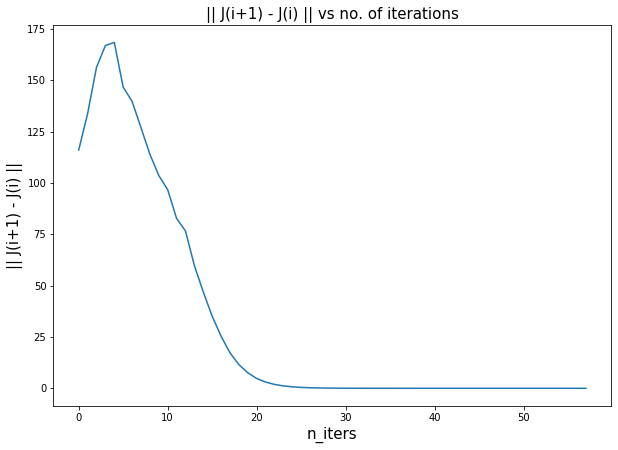

In [6]:
norms = []
for i in range(len(value_grids)-1): 
    norms.append(np.linalg.norm(value_grids[i+1] - value_grids[i]))

fig,axes=plt.subplots(figsize=(10,7),nrows=1)
axes.plot(norms,)
axes.set_xlabel('n_iters', fontsize=15)
axes.set_ylabel('|| J(i+1) - J(i) ||', fontsize=15)
axes.set_title('|| J(i+1) - J(i) || vs no. of iterations', fontsize=15)
plt.show()

For Policies (Pi), the directions are as follows:
0: N ↑
1: E →
2: S ↓
3: W ←



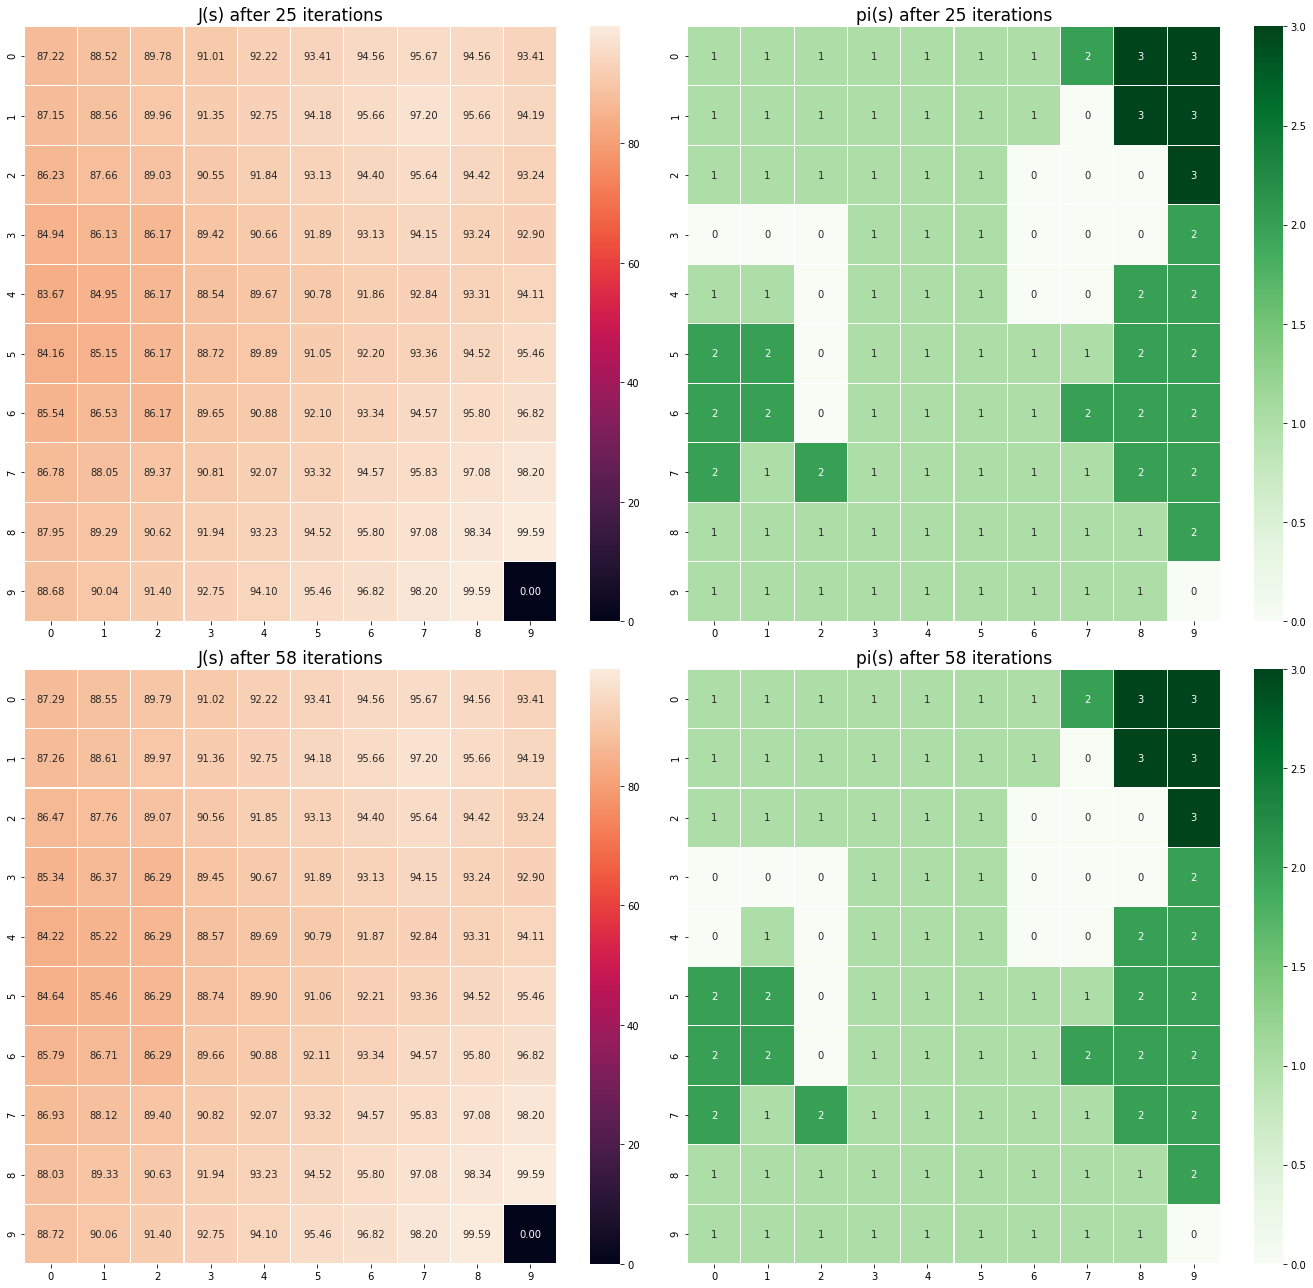

In [7]:
print('For Policies (Pi), the directions are as follows:')
print("0: N ↑\n1: E →\n2: S ↓\n3: W ←\n",sep='')

import seaborn as sns
fig,axes=plt.subplots(figsize=(19,18),nrows=2,ncols=2)
n_iter=len(policies)-1 # final iteration
inds=[25,n_iter]
for i in range(2):
  ax=axes[i][0]
  sns.heatmap(value_grids[inds[i]],annot=True,fmt='.2f', linewidths=.1,ax=ax)
  ax.set_title('J(s) after '+str(inds[i])+' iterations',fontsize=17)

  ax=axes[i][1]
  sns.heatmap(policies[inds[i]],annot=True, linewidths=.1, cmap="Greens", ax=ax)
  ax.set_title('pi(s) after '+str(inds[i])+' iterations',fontsize=17)

plt.tight_layout()
plt.show()